# Transferencia de Aprendizaje (Transfer Learning)

## 1. Introducción Teórica

La Transferencia de Aprendizaje es una técnica fundamental en Deep Learning que nos permite aprovechar
modelos pre-entrenados en grandes conjuntos de datos para aplicarlos a nuestros problemas específicos.

Ventajas principales:
- Ahorro significativo de tiempo y recursos computacionales
- Mejor rendimiento con conjuntos de datos pequeños
- No requiere partir desde cero en el entrenamiento

En este cuaderno, vamos a clasificar imágenes de babuinos y jirafas utilizando MobileNetV2,
una red neuronal pre-entrenada en el dataset ImageNet.


## 2. Preparación del Dataset
# Descomprimimos las imágenes de ejemplo

Primero, vamos a preparar nuestro conjunto de datos local.
Descomprimimos los archivos zip que contienen las imágenes de babuinos y jirafas.

In [3]:
!unzip perro/perros.zip -d perro

Archive:  perro/perros.zip
   creating: perro/perros/
  inflating: perro/perros/0096_000_es-es.jpg  
  inflating: perro/perros/01-dog-baby-talk-NationalGeographic_2283205.webp  
  inflating: perro/perros/03e4f5cab257-perro-nervios-t.jpg  
  inflating: perro/perros/1200px-Coat_types_3.jpg  
  inflating: perro/perros/123004876_3609155692482412_2049794398247296546_n-1024x577.jpg  
  inflating: perro/perros/201_1.jpg  
  inflating: perro/perros/330px-1Dog-rough-collie-portrait.jpg  
  inflating: perro/perros/37352d1c598a-perros-miniatura-a.jpg  
  inflating: perro/perros/500px-Collage_of_Nine_Dogs.jpg  
  inflating: perro/perros/5cb1f9400891d9da5a4926d7814bd1b89127ecba-1300x867.jpg  
  inflating: perro/perros/63e24a5841e09.jpeg  
  inflating: perro/perros/662693884_223269248_1024x576.jpg  
  inflating: perro/perros/665f0461a9ae0.jpeg  
  inflating: perro/perros/823f515c-8143-4044-8f13-85ea1ef58f3a_source-aspect-ratio_default_0.jpg  
  inflating: perro/perros/ADAPTIL-_20Como_20educar_20a_20

In [5]:
!unzip gato/gatos.zip -d gato

Archive:  gato/gatos.zip
   creating: gato/gatos/
  inflating: gato/gatos/05f18bab-8bb9-4cf3-9e48-73452526cf95_16-9-discover-aspect-ratio_default_0.jpg  
  inflating: gato/gatos/10-datos-curiosos-sobre-los-gatos-veterinaria-aguara.webp  
  inflating: gato/gatos/17301945271896.jpg  
  inflating: gato/gatos/1920-X-490-IMG-BLOG-QUE-FRUTAS-PUEDEN-COMER-TU-MININO.webp  
  inflating: gato/gatos/199294238_315554720182029_2579766536124680755_n_600x600.jpg  
  inflating: gato/gatos/216263bf-4160-4b17-abd0-8c94d2459b43_16-9-discover-aspect-ratio_default_1099866.jpg  
  inflating: gato/gatos/41c7e7ce298604b0801fc2b1b76371a47e9ebb83-950x633.jpg  
  inflating: gato/gatos/4e1211c1-1520-41a7-aabb-42c2e03d1731_alta-libre-aspect-ratio_default_0.jpg  
  inflating: gato/gatos/6346a7d3ec310.jpeg  
  inflating: gato/gatos/64d3a75cbcd35.r_d.2113-1414-1062.jpeg  
  inflating: gato/gatos/650f53de32544.jpg  
  inflating: gato/gatos/6581e20bbf2efeffbb33b6c4_chatblancnoir.webp  
  inflating: gato/gatos/675082f52

In [6]:
!rm -rf perro/perros.zip
!rm -rf gato/gatos.zip

In [7]:
#Crear un set de datos (ya no en memoria)

!mkdir dataset
!cp -r perro dataset/perro
!cp -r gato dataset/gato

## 3. Aumento de Datos (Data Augmentation)

El aumento de datos es una técnica crucial que nos permite:
- Aumentar artificialmente nuestro conjunto de datos
- Mejorar la generalización del modelo
- Evitar el sobreajuste (overfitting)

Aplicaremos las siguientes transformaciones:
- Reescalado de píxeles a valores entre 0 y 1
- Rotaciones aleatorias (±10 grados)
- Desplazamientos horizontales y verticales (±15%)
- Deformaciones (shear)
- Zoom variable (entre 70% y 130%)


In [8]:
#Aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.15,
    height_shift_range = 0.15,
    shear_range = 5,
    zoom_range = [0.7, 1.3],
    validation_split = 0.2
)

data_gen_entrenamiento = datagen.flow_from_directory("/content/dataset",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="training")

data_gen_pruebas = datagen.flow_from_directory("/content/dataset",
                                                     target_size=(224,224),
                                                     batch_size=32, shuffle=True,
                                                     subset="validation")

Found 625 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


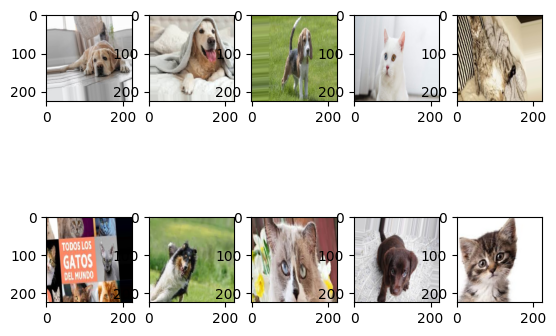

In [9]:
import matplotlib.pyplot as plt

for imagenes, etiquetas in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imagenes[i])

  break
plt.show()

##Construcción del Modelo con Transfer Learning

Utilizaremos MobileNetV2 como modelo base, que:
- Es una red neuronal eficiente diseñada para dispositivos móviles
- Está pre-entrenada en más de 1 millón de imágenes de ImageNet
- Tiene una excelente relación rendimiento/recursos


In [10]:
import tensorflow as tf
import tensorflow_hub as hub

url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224, 224, 3))

In [11]:
#Importante
#Congelar las capas
mobilenetv2.trainable = False

In [16]:
# Construir el modelo funcional
input_layer = tf.keras.Input(shape=(224, 224, 3))
x = mobilenetv2(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Agregar una capa de pooling
output_layer = tf.keras.layers.Dense(2, activation="softmax")(x)

modelo = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [17]:
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Entrenamiento del Modelo

Entrenamos el modelo durante 20 épocas, monitoreando tanto el rendimiento
en entrenamiento como en validación.


In [18]:
EPOCAS = 20
entrenamiento = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7004 - loss: 0.5870 - val_accuracy: 0.9097 - val_loss: 0.2746
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step - accuracy: 0.9106 - loss: 0.2111 - val_accuracy: 0.9355 - val_loss: 0.1890
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - accuracy: 0.9301 - loss: 0.1679 - val_accuracy: 0.9484 - val_loss: 0.1470
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 570ms/step - accuracy: 0.9550 - loss: 0.1280 - val_accuracy: 0.9419 - val_loss: 0.1490
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 614ms/step - accuracy: 0.9632 - loss: 0.1002 - val_accuracy: 0.9355 - val_loss: 0.1473
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 560ms/step - accuracy: 0.9724 - loss: 0.0826 - val_accuracy: 0.9548 - val_loss: 0.1279
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - accuracy: 0.9553 - loss: 0.1132 - val_accuracy: 0.9161 - val_loss: 0.1520
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 553ms/step - accuracy: 0.9796 - loss: 0.0768 - val_accurac

## Función de Predicción

Creamos una función para realizar predicciones sobre nuevas imágenes.
Esta función:
1. Carga la imagen
2. La preprocesa al formato correcto
3. Realiza la predicción usando nuestro modelo


In [19]:
from PIL import Image
import cv2

def categorizar(ruta):
  img = Image.open(ruta)
  img = img.convert("RGB")
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224, 224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)

## Pruebas del Modelo

Probamos el modelo con algunas imágenes de ejemplo:
0 = Babuino
1 = Jirafa


In [23]:
ruta = "/content/gato/gatos/05f18bab-8bb9-4cf3-9e48-73452526cf95_16-9-discover-aspect-ratio_default_0.jpg"
prediccion = categorizar(ruta)
print(prediccion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
0


In [ ]:
ruta = ".jpeg"
prediccion = categorizar(ruta)
print(prediccion)